# Recommendations KMeans

## 💡 1. Introduction

## 📚 2. Preparations

### 2.1 Importing libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from scipy.sparse import coo_matrix, csr_matrix, csc_matrix

### 2.2 Importing datasets
The data storage solution provides two dataframes. We can easily import them with the use of storage magic. Storage magic is for lightweight persistance between notebooks. It stores variables, aliases and macros in the IPython's database.

The data storage solution can be found here:<br>
https://github.com/i442124/SuperScope/tree/main/notebooks/

More info about storage magic can be found here:<br>
https://ipython.readthedocs.io/en/stable/config/extensions/storemagic.html

In [2]:
%store -r games ratings

In [3]:
games.head()

,title,platform,publisher,genres
0,The Legend of Zelda: Ocarina of Time,Nintendo 64,Nintendo,"[Action Adventure, Fantasy]"
1,Tony Hawk's Pro Skater 2,PlayStation,Activision,"[Skateboarding, Sports, Alternative]"
2,Grand Theft Auto IV,PlayStation 3,Rockstar Games,"[Action Adventure, Modern, Open-World]"
3,SoulCalibur,Dreamcast,Namco,"[Fighting, Action, 3D]"
4,Grand Theft Auto IV,Xbox 360,Rockstar Games,"[Action Adventure, Modern, Open-World]"


In [4]:
ratings.head()

,title,platform,meta_score,review_critic
0,The Legend of Zelda: Ocarina of Time,Nintendo 64,100.0,Hot Games
1,The Legend of Zelda: Ocarina of Time,Nintendo 64,100.0,GameShark
2,The Legend of Zelda: Ocarina of Time,Nintendo 64,100.0,Cincinnati Enquirer
3,The Legend of Zelda: Ocarina of Time,Nintendo 64,100.0,Nintendophiles
4,The Legend of Zelda: Ocarina of Time,Nintendo 64,100.0,Electronic Gaming Monthly


In [5]:
print(f'The dataset contains: {len(ratings)} ratings of {len(games)} games.')

The dataset contains: 422475 ratings of 18295 games.


## 🧪3. Experimentation
Lets start off by experimenting a little with KMeans, to get a feel of how this works on the dataset. KMeans operates best on data where the number of categories is known. The first thing that comes into my mind are genres of the video games. Lets start off by calulating for each user their average rating of all genres available.

In [7]:
def avg_genre_matrix(ratings):
    # Split each game into multiple rows
    # for each genre they have, this makes
    # it easier to calculate the average score
    genre_ratings = pd.merge(games, ratings)
    genre_ratings = genre_ratings.explode(column='genres')

    # Calcluate average of each review_critic of each genre
    genre_ratings = genre_ratings.groupby(['review_critic', 'genres']).mean()
    genre_ratings = genre_ratings.reset_index().pivot('review_critic', 'genres', 'meta_score')
    return genre_ratings

In [8]:
genre_ratings = avg_genre_matrix(ratings)
genre_ratings.iloc[:10, :10]

genres,2D,3D,4X,Action,Action Adventure,Action RPG,Adventure,Alternative,Application,Arcade
review_critic,,,,,,,,,,
1UP,74.919811,66.234657,86.25,68.013678,69.178503,70.718919,68.814815,66.880000,80.0,67.941423
360 Gamer Magazine UK,67.000000,60.000000,NaN,68.512397,66.578947,76.666667,60.000000,64.000000,NaN,70.350877
3DAvenue,72.800000,76.120000,NaN,77.053846,77.081967,78.090909,71.600000,72.666667,NaN,80.708333
3DJuegos,79.644699,76.094118,82.50,76.800560,77.829060,79.241877,76.370504,76.090909,70.5,76.445946
4Players.de,76.763948,71.652720,77.15,72.563559,73.653772,76.970000,73.478261,73.666667,NaN,69.732441
9Lives,80.615385,82.615385,NaN,77.835443,78.432432,79.333333,79.000000,81.000000,72.0,77.086957
Absolute Games,72.666667,67.347826,70.75,63.207071,66.804348,67.641026,63.412698,NaN,NaN,62.379845
Absolute Playstation,90.333333,87.090909,NaN,86.807692,90.315789,86.750000,NaN,79.833333,NaN,88.200000
AceGamez,77.050505,72.181818,91.25,74.171225,73.804627,72.674157,70.069307,69.848485,60.0,74.802048


We can see a few NaN values, which indicates that this reviewer has not scored a game in this genre.

### 3.1 Action vs Adventure

Now that we have the averages of all genres for each review critic, lets compare two of the most popular genres with each other. We can use a scatter plot where the scores of the action genre on the X axis and the adventure genre on the Y axis. Spots on the bottom left indicate that the critic doesn't like action nor adventure, while the top right indicates that the critic really loves action and adventure.

In [9]:
action_adventure = genre_ratings[['Action', 'Adventure']]
action_adventure = action_adventure[action_adventure['Action'].notna()]
action_adventure = action_adventure[action_adventure['Adventure'].notna()]

<AxesSubplot:xlabel='Action', ylabel='Adventure'>

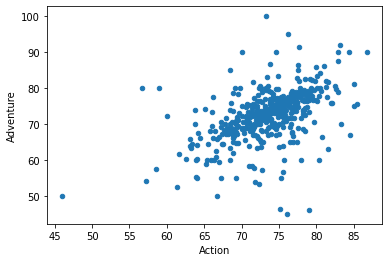

In [10]:
action_adventure.plot.scatter(x='Action', y='Adventure')

It looks like most people enjoy action adventure as the center of all points is located in the top right. Lets check out how KMeans performs when we split these review scores into two different groups. I'd expect a segmentation somewhere around the (75,75) mark.

<AxesSubplot:xlabel='Action', ylabel='Adventure'>

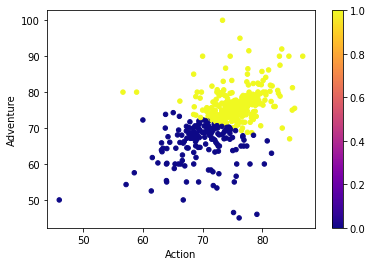

In [11]:
clusterer = KMeans(n_clusters=2)
predictions = clusterer.fit_predict(action_adventure)

fig, ax = plt.subplots(1, 1)
action_adventure.plot.scatter(ax=ax, x='Action', y='Adventure', c=predictions, colormap='plasma')

As we can see, the cluster that the critic belongs to depends on if they rate adventure higher than action (or visa versa). Lets check what happens when we increase the number of clusters.

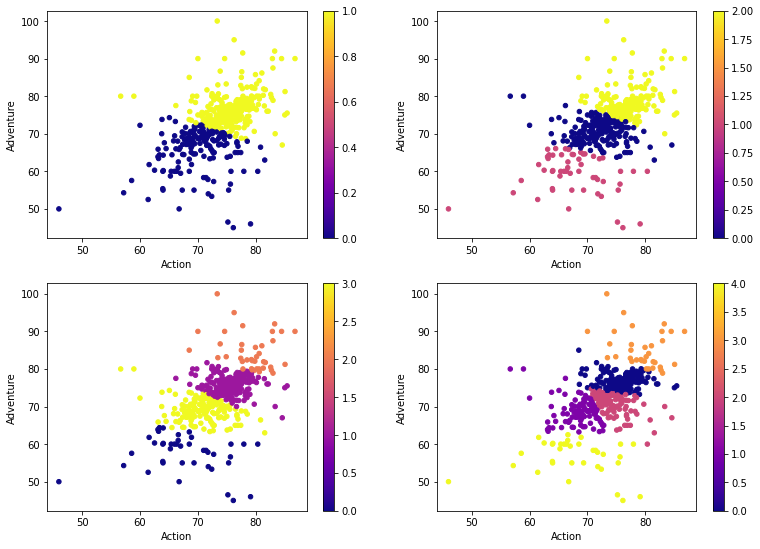

In [12]:
k_values = [2, 3, 4, 5]
fig, axs = plt.subplots(2, 2, figsize=(12.8, 9.2))

for i, k in enumerate(k_values): 
    clusterer = KMeans(n_clusters=k)
    predictions = clusterer.fit_predict(action_adventure)
    action_adventure.plot.scatter(ax=axs.ravel()[i], x='Action', y='Adventure', c=predictions, colormap='plasma')

We start to see that the more clusters we use, the more similar the taste of each cluster blends in with the others, but what would be the most optimal value?

### 3.2 Finding Optimal K

There are several techniques we can use to determine the optimal value of K. The most popular method for finding the optimal value is known as 'The Elbow Method'. Another method I found is known as the silhouette-method which I'd like to try out as well, to see how they comapre with each other.

Useful sources: <br>
https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set<br>
https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb<br>

In [13]:
def elbow_method(k, data):
    clusterer = KMeans(n_clusters=k)
    pred = clusterer.fit_predict(data)
    return clusterer.inertia_

In [14]:
def silhouette_method(k, data):
    kmeans = KMeans(n_clusters=k)
    pred = kmeans.fit_predict(data)
    return silhouette_score(data, pred)

In [15]:
def plot_optimal_k(possible_k_values, scores):
    fig = plt.figure(figsize=(16, 6))
    
    xticks = np.arange(
        min(possible_k_values),
        max(possible_k_values)+1, 12)
    
    plt.xticks(xticks, rotation=0)
    plt.grid(axis='both', which='both')
    plt.plot(possible_k_values, scores)

Lets start off with gathering all possible k values we can go for. KMeans is limited to the amount of entires in the dataset, which for us is the total amount of critics. We can use this scope to generate a range between 2 (the miniumum) and the amount of critics (the maximum). We use a stride of 8 to lower the performance cost.

In [16]:
possible_k_values = range(2, len(action_adventure), 4)

First we will plot the Elbow Method. The elbow method is known for ... it's elbow shape. The value we are looking for is represented by the bend of the elbow. This point should be an indication how many (if any!?) clusters we have in the dataset. So let's figure out how many clusters we have in the action/adventure genre.

In [17]:
#squared_distances = [elbow_method(k, action_adventure) for k in possible_k_values]
#plot_optimal_k(possible_k_values, squared_distances)

Looks like the sweetspot is rougly at 20 clusteres. Let's compare this with the silhouette score. With the silhouette method we are most likley intrested in the highest peak on the chart.

In [18]:
#silhouette_scores = [silhouette_method(k, action_adventure) for k in possible_k_values]
#plot_optimal_k(possible_k_values, silhouette_scores)

Whats intresting about this plot is that it's peak is already at two, which happens to be the amount of genres that we are trying to compare. Ignoring that part, we see a few peakes with a gradual decline at around 134 clusters. Depending on what kind of clustering we need (blended or abstract) we can choose accordingly.

## ⚙️ 4. Settings

In [19]:
## Amount of clusters that the
# reviewers should be devided into
K_CLUSTERS = 7

## Score reduction strength for games
## with a low amount of reviews in cluster
PENALIZER_STRENGTH = 1

## Platforms that you want
## to get recommendations for
SUPPORTED_PLATFORMS = ['Switch']

## How to resolve NaN values for 
## critics that haven't played a genre
## possible values: 'drop', 'mean', 'zeros'
IMPUTATION_RESOLVER = 'drop'

## Minimum amount of reviews
## that the game must have
MIN_REVIEWS_COUNT = 0

## Minimum amount of reviews that
## the critic must have written
MIN_REVIEWS_WRITTEN = 0

## Minimum amount of reviews in
## for a genre in order to be clustered
MIN_REVIEWS_IN_GENRE = 75

In [20]:
MY_GAME_REVIEWS = pd.DataFrame({
    'title': [
        'Xenoblade Chronicles: Definitive Edition',
        'The Legend of Zelda: Breath of the Wild',
        'Super Smash Bros. Ultimate',
        'Super Mario Oddesey'
    ],
    'platform': 'Switch',
    'review_critic': 'Self',
    'meta_score': [100, 92, 95, 80]
})

MY_GAME_REVIEWS

,title,platform,review_critic,meta_score
0,Xenoblade Chronicles: Definitive Edition,Switch,Self,100
1,The Legend of Zelda: Breath of the Wild,Switch,Self,92
2,Super Smash Bros. Ultimate,Switch,Self,95
3,Super Mario Oddesey,Switch,Self,80


## 🧮 5. User-Genre Matrix 
Now that we have confirmed that there is a strong releation between the review scores of critics and the genre of a game, we can start looking at the bigger picture. Instead of comparing two genres with each other, we want to compare them all with each other.

### 5.1 Feature selection
Lets start off by filting some of the ratings on our list that we don't want/need. A smaller dataset will improve the performance a lot. Critics that don't write enough reviews and games that don't have enough reviews can be dropped since their accuraccy for being a good recommendation is low to begin with.

In [21]:
ratings = ratings[ratings.groupby(['review_critic'])['review_critic'].transform('size') > MIN_REVIEWS_WRITTEN]
ratings = ratings[ratings.groupby(['title', 'platform'])['review_critic'].transform('size') > MIN_REVIEWS_COUNT]

Now we have two options to determine which cluster the user will belong to. The first approach is to fit the user along with all the critics. This allows the user to become an outlier when he has an unpopular opinion which will result in no recommendations. 

The second approach is to predict which cluster the users belongs to after fitting the ratings of the other critics. This guarentees that the user will be droppend in a cluster with atleast some review ratings, but might not be a good fit. For the use-case I'm going for, I don't want to get recommendations when I've become an outlier so I append my reviews with the other ratings.

In [22]:
ratings = ratings.append(MY_GAME_REVIEWS)

Next we create a genre matrix (like we did before) but this time with all genres that we have available. We drop all genres that don't have enough games for them as well as genres not in our game collection to avoid an unnecessary large matrix.

In [23]:
genre_ratings = avg_genre_matrix(ratings)
genre_ratings.dropna(inplace=True, axis=1, thresh=MIN_REVIEWS_IN_GENRE)
genre_ratings = genre_ratings[avg_genre_matrix(MY_GAME_REVIEWS).columns]

<AxesSubplot:>

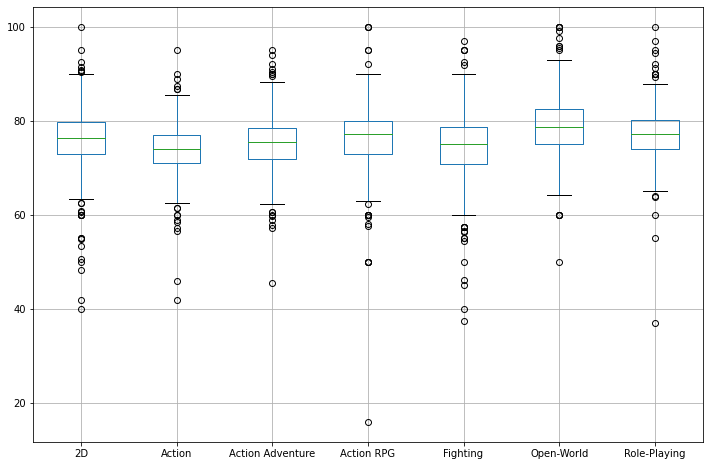

In [24]:
genre_ratings.boxplot(figsize=(12, 8))

### 5.2 Imputation

In [25]:
genre_ratings.isnull().sum()

genres
2D                  34
Action               3
Action Adventure     8
Action RPG          31
Fighting            53
Open-World          87
Role-Playing        16
dtype: int64

In [26]:
if IMPUTATION_RESOLVER == 'drop':
    genre_ratings = genre_ratings.dropna()
elif IMPUTATION_RESOLVER == 'zeros':
    genre_ratings = genre_ratings.fillna(value=0)
elif IMPUTATION_RESOLVER == 'mean':
    genre_ratings = genre_ratings.fillna(genre_ratings.mean())

### 5.3 Standardisation
When applying K-means clusterings it's best to always standardize the data before fitting. Standardisation reduces the risks of miscalculations between the distances of data. We can easily apply this by using the preprocessing library provided by sklearn.

In [27]:
standard_scaler = StandardScaler(with_mean=True, with_std=True)
standardized_matrix = standard_scaler.fit_transform(genre_ratings)

## 🧠 6. KMeans Clustering

### Cheatsheet

In [28]:
possible_k_values = range(2, len(genre_ratings), 3)

In [ ]:
squared_distances = [elbow_method(k, standardized_matrix) for k in possible_k_values]
plot_optimal_k(possible_k_values, squared_distances)

### 6.1 Training the model
https://stats.stackexchange.com/questions/450445/<br>
https://stats.stackexchange.com/questions/267322/<br>

In [ ]:
clusterer = KMeans(n_clusters=K_CLUSTERS, random_state=42)
predictions = clusterer.fit_predict(standardized_matrix)
predictions

In [ ]:
genre_ratings['cluster'] = predictions
genre_ratings['cluster'].value_counts()

In [ ]:
ratings = ratings.merge(genre_ratings.reset_index()[['review_critic','cluster']])
ratings['cluster'].value_counts()

In [ ]:
import warnings
with warnings.catch_warnings(record=True):
    sns.pairplot(genre_ratings, hue='cluster', palette='tab10')

### 6.2 Predictions

In [ ]:
#my_genre_ratings = avg_genre_matrix(MY_GAME_REVIEWS)
#my_standard_matrix = standard_scaler.fit_transform(my_genre_ratings)

In [ ]:
#cluster_id = clusterer.predict(my_standard_matrix)[0]
#cluster_id

In [ ]:
cluster_id = ratings[ratings['review_critic'] == 'Self']['cluster'].iloc[0]
cluster_id

## 📊 7. Recommendations
After determining which cluster I would belong to we can start getting all the ratings of the critics that have the same intrests as us. We no longer care about the opinions of other reviewers because they have intrests in genres we don't care about.

In [ ]:
cluster = ratings[ratings['cluster'] == cluster_id]
cluster = cluster[cluster['platform'].isin(SUPPORTED_PLATFORMS)]

Great, now let's grab the mean of all the game scores and sort them by highest scored game, this should be our top recommendation!

In [ ]:
cluster_ratings = cluster.groupby(['platform', 'title']).mean().reset_index()
cluster_ratings.sort_values(['meta_score'], inplace=True, ascending=False)
cluster_ratings.head(20)

Not bad suggestions at all, but some of these are questionable at best. *'Sayonara Wild Hearts'*, *'Subsurface Circular'* and *'Baba is You'* are games I've certainly never heard of, so why are they this high up on the list?

In [ ]:
cluster_sizes = cluster.groupby(['platform', 'title']).agg({'title':'size', 'meta_score':'mean'})
cluster_sizes = cluster_sizes.rename(columns={'title':'count'}).reset_index()
cluster_sizes.sort_values(['count'], inplace=True, ascending=False)
cluster_sizes.head(20)

When we start sorting on the total amount of reviews for a game, the suggestions make a lot more sense to me personally. Most of these games I've actually seen/played or at the least heard of. So, we need to find a balance between the average review score and the total amount of reviews written for that game. If we only have one review for a game in the cluster that has scored really high it's probably still not a good sugesstion for users to play. We need some kind of way to "punish" games that don't have a lot of recommendations.

In [ ]:
%%html
<style>table {align:left;display:block}</style>

We want to scale down the scores by the amount of reviews we have. The higher we get to 'infinity' the closer we want to get to the actual mean score. I think the desidered effect is best explained with a simple table that gives you a rough idea of what we want to achieve.

|  X  |   1   |   2   |   3   |   4   |   5   |   6   |   7   |   8   |   9   |
| --- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- |
|  Y  |  0.5  | 0.667 | 0.75  |  0.8  | 0.83  | 0.857 | 0.875 | 0.888 |  0.9  |

Here we can see that as X grows, the Y increases as well, but the effect weakens over time. Y will be the multiplication factor that we apply on the `meta_score`. If we have one review, the score gets devided in half, if we have two reviews it get's devided by 2/3 etc and if we have three reviews, the score get's devided by 3/4 and so forth.

The formula that belongs to the table above is the following:<br>
`Y = (X)/(X+1) * score`

The strength of the punishment is decided by the magic number `PENALIZER_STRENGTH`. If we were to increase this number the punishments get stronger and if we were to lower this number the punishments become weaker. In this case I want this effect to be pretty strong because I'd like to avoid recommending possible poor games over not recommending good games! Now let's apply this formula to our recommendations and see the results.

You can expiriment with the fomula in [WolframAlpha](https://www.wolframalpha.com/input/?i=x%2F%28x%2B1%29+from+0+to+10) or by playing with the settings.

In [ ]:
weight = lambda x: (x['count'])/(x['count']+PENALIZER_STRENGTH) * x['meta_score']

In [ ]:
recommendations = pd.DataFrame(cluster_sizes)
recommendations['recommendation_score'] = weight(recommendations)
recommendations.sort_values(['recommendation_score'], ascending=False).head(20)

And there we have it, the recommendations based on my personal preference.

## 📝 8. Conclusion